In [1]:
import torch
import torch.nn
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import fine_tune
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
TASK = 'qnli'
TEACHER_EXP = 'teacher_base'
TMODEL = 'bert'
TCKPT = 8000
STUDENT_EXP = 'PKD2'
SMODEL = 'bert'
SCKPT = 13000
DATASET = 'dev'
SDEVICE = 0
TDEVICE = 0
BATCH_SIZE = 1

In [3]:
teacher_config = fine_tune.config.TeacherConfig.load(
    experiment=TEACHER_EXP,
    model=TMODEL,
    task=TASK
)
teacher_config.device_id = TDEVICE
teacher_config.dataset = DATASET
print(teacher_config)


+---------------------------------------+
| configuration     | value             |
+---------------------------------------+
| accum_step        | 2                 |
| amp               | 0                 |
| batch_size        | 32                |
| beta1             | 0.9               |
| beta2             | 0.999             |
| ckpt_step         | 1000              |
| dataset           | dev               |
| device_id         | 0                 |
| dropout           | 0.1               |
| eps               | 1e-08             |
| experiment        | teacher_base      |
| log_step          | 500               |
| lr                | 3e-05             |
| max_norm          | 1.0               |
| max_seq_len       | 128               |
| model             | bert              |
| num_class         | 2                 |
| ptrain_ver        | bert-base-uncased |
| seed              | 42                |
| task              | qnli              |
| total_step        | 9822       

In [4]:
fine_tune.util.set_seed_by_config(teacher_config)

In [5]:
student_config = fine_tune.config.StudentConfig.load(
    experiment=STUDENT_EXP,
    model=SMODEL,
    task=TASK
)
student_config.device_id = SDEVICE
student_config.dataset = DATASET
print(student_config)


+-------------------------------------------+
| configuration       | value               |
+-------------------------------------------+
| accum_step          | 1                   |
| amp                 | 0                   |
| batch_size          | 32                  |
| beta1               | 0.9                 |
| beta2               | 0.999               |
| ckpt_step           | 1000                |
| d_emb               | 128                 |
| d_ff                | 3072                |
| d_model             | 768                 |
| dataset             | dev                 |
| device_id           | 0                   |
| dropout             | 0.1                 |
| eps                 | 1e-08               |
| experiment          | PKD2                |
| log_step            | 100                 |
| lr                  | 5e-05               |
| max_norm            | 1.0                 |
| max_seq_len         | 128                 |
| model               | bert     

In [6]:
dataset = fine_tune.util.load_dataset_by_config(
    config=teacher_config
)

2021/05/19 13:46:25 - INFO - fine_tune.task -   Start loading task QNLI dataset dev.
Loading QNLI dev: 5463it [00:00, 403975.37it/s]
2021/05/19 13:46:25 - INFO - fine_tune.task -   Number of samples: 5463
2021/05/19 13:46:25 - INFO - fine_tune.task -   Finish loading task QNLI dataset dev.


In [7]:
teacher_tknr = fine_tune.util.load_teacher_tokenizer_by_config(
    config=teacher_config
)
student_tknr = fine_tune.util.load_student_tokenizer_by_config(
    config=student_config
)

In [8]:
TEACHER_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=teacher_config.experiment,
    model=teacher_config.model,
    task=teacher_config.task
)
TEACHER_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    TEACHER_EXP_NAME
)
print(TEACHER_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/teacher_base_bert_qnli


In [9]:
teacher_model = fine_tune.util.load_teacher_model_by_config(
    config=teacher_config
)
teacher_model.load_state_dict(
    torch.load(
        os.path.join(TEACHER_EXP_DIR, f'model-{TCKPT}.pt'),
        map_location=teacher_config.device
    )
)

<All keys matched successfully>

In [10]:
STUDENT_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=student_config.experiment,
    model=student_config.model,
    task=student_config.task
)
STUDENT_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    STUDENT_EXP_NAME
)
print(STUDENT_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/PKD2_bert_qnli


In [11]:
student_model = fine_tune.util.load_student_model_by_config(
    config=student_config,
    tokenizer=student_tknr,
    init_from_pre_trained=False
)
student_model.load_state_dict(
    torch.load(
        os.path.join(STUDENT_EXP_DIR, f'model-{SCKPT}.pt'),
        map_location=student_config.device
    )
)

<All keys matched successfully>

In [12]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    collate_fn=dataset.create_collate_fn(),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [13]:
cosine_sim = torch.nn.CosineSimilarity()

y_ground = []
y_teacher = []
y_student = []
correct_sim = []
false_sim = []
false_pos_sim = []
false_neg_sim = []

In [14]:
student_model.eval()
teacher_model.eval()


with torch.no_grad():
    for text, text_pair, label in tqdm(dataloader):
        teacher_encode = teacher_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=teacher_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        teacher_input_ids = teacher_encode['input_ids']
        teacher_token_type_ids = teacher_encode['token_type_ids']
        teacher_attention_mask = teacher_encode['attention_mask']

        student_encode = student_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=student_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        student_input_ids = student_encode['input_ids']
        student_token_type_ids = student_encode['token_type_ids']
        student_attention_mask = student_encode['attention_mask']

        t_logits, t_cls = teacher_model(
            input_ids = teacher_input_ids.to(teacher_config.device),
            token_type_ids = teacher_token_type_ids.to(teacher_config.device),
            attention_mask = teacher_attention_mask.to(teacher_config.device)
        )

        s_logits, s_cls = student_model(
            input_ids = student_input_ids.to(student_config.device),
            token_type_ids = student_token_type_ids.to(student_config.device),
            attention_mask = student_attention_mask.to(student_config.device)
        )

        gt = label[-1]
        t_pred_label = F.softmax(t_logits, dim=-1).argmax(dim=-1).to('cpu').detach().item()
        s_pred_label = F.softmax(s_logits, dim=-1).argmax(dim=-1).to('cpu').detach().item()


        y_ground.append(gt)
        y_teacher.append(t_pred_label)
        y_student.append(s_pred_label)

        if gt == t_pred_label and gt == s_pred_label:
            correct_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())
        elif gt == t_pred_label and gt != s_pred_label:
            false_pos_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())
        elif gt != t_pred_label and gt == s_pred_label:
            false_neg_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())
        else:
            false_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())

    


100%|██████████| 5463/5463 [01:01<00:00, 88.11it/s]


## Confusion matrix of teacher and student outputs

In [15]:
cm = confusion_matrix(y_teacher, y_student)

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

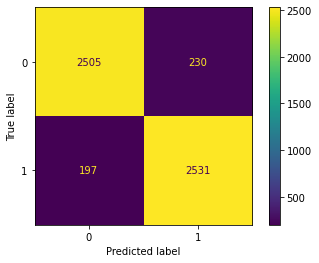

In [17]:
disp.plot(values_format='d')

## Confusion matrix of teacher and ground truth

In [18]:
cm2 = confusion_matrix(y_ground, y_teacher)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

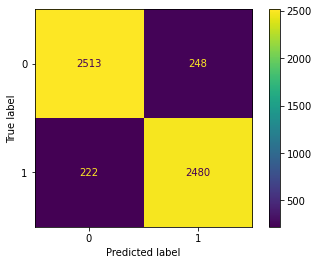

In [19]:
disp2.plot(values_format='d')

## Confusion matrix of student and ground truth

In [20]:
cm3 = confusion_matrix(y_ground, y_student)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)

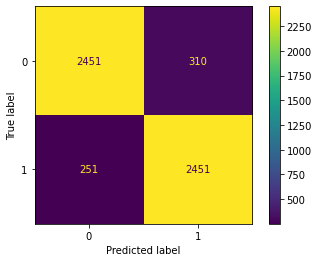

In [21]:
disp3.plot(values_format='d')

In [22]:
print(y_ground.count(0))
print(y_teacher.count(0))
print(y_student.count(0))

2761
2735
2702


In [23]:
print(y_ground.count(1))
print(y_teacher.count(1))
print(y_student.count(1))

2702
2728
2761


In [24]:
t_acc = accuracy_score(y_ground, y_teacher)
print(t_acc)

0.9139666849716274


In [25]:
s_acc = accuracy_score(y_ground, y_student)
print(s_acc)

0.8973091707852828


In [26]:
len(dataset) * (t_acc - s_acc)

91.0000000000002

In [27]:
y_teacher = np.asarray(y_teacher)
y_ground = np.asarray(y_ground)
y_student = np.asarray(y_student)

In [28]:
correct_sim = np.asarray(correct_sim)
print(correct_sim.size)
false_sim = np.asarray(false_sim)
print(false_sim.size)
false_pos_sim = np.asarray(false_pos_sim)
false_neg_sim = np.asarray(false_neg_sim)
print(false_pos_sim.size)
print(false_neg_sim.size)

4734
302
259
168


In [29]:
print(correct_sim[correct_sim > 0.5])
print(correct_sim[correct_sim > 0.5].size)

[0.77435988 0.66550493 0.74144709 ... 0.83594471 0.77431858 0.79557705]
4401


In [30]:
print(correct_sim[correct_sim < 0.5])
print(correct_sim[correct_sim < 0.5].size)

[-0.55578274 -0.08138601 -0.02257366 -0.6695388   0.26116717 -0.25689858
 -0.3242088   0.39353538  0.47415549  0.35677767  0.32028764  0.00279212
  0.02251788 -0.08054389  0.34239244  0.10005707  0.43767059  0.09644849
  0.39366224 -0.16817072  0.41969928  0.31810361 -0.1173363   0.29357606
 -0.19803287 -0.02717783 -0.36468261  0.0323259  -0.09265353 -0.21974626
  0.38720682  0.42135063 -0.49603534  0.46175319 -0.06000948 -0.35064989
 -0.02071612  0.02065686  0.35664326  0.14835134  0.46051764  0.34164846
 -0.26409978 -0.28100514  0.16275121  0.04198778  0.48396534  0.07345781
  0.29425928  0.32470363 -0.3578074  -0.14896481 -0.05522377  0.2127398
  0.01171297  0.18381587  0.15533949 -0.19526261 -0.18472385  0.16906883
  0.42624334 -0.36818641  0.35247236  0.32883456  0.49459371  0.49529454
  0.37675717  0.24030836 -0.40024248  0.06381635  0.35497457 -0.3901726
  0.24672835  0.12503594  0.32615873  0.29707396 -0.01651985  0.25188518
  0.4435674  -0.39375865 -0.31401801 -0.45182642  0.3

In [31]:
print(false_sim[false_sim > 0.5])
print(false_sim[false_sim > 0.5].size)

[0.62476957 0.89680791 0.69428694 0.93434566 0.83345205 0.9087553
 0.88717949 0.78315508 0.78112316 0.86004376 0.94008732 0.67280585
 0.86850357 0.81232059 0.81183106 0.70763785 0.595038   0.7446295
 0.87086016 0.79018044 0.82373035 0.88597995 0.93867189 0.79749602
 0.801691   0.9031381  0.71018773 0.67346507 0.842623   0.88594097
 0.77338856 0.91250741 0.84002268 0.65511125 0.81477129 0.54096848
 0.8061496  0.77866644 0.85545915 0.72887093 0.62677127 0.84102786
 0.81409335 0.72003591 0.79974127 0.93728507 0.64628392 0.71533477
 0.7238149  0.75810087 0.75480682 0.64436746 0.68796384 0.83412719
 0.89674693 0.81083906 0.93158108 0.78178692 0.78342748 0.88670719
 0.71414638 0.91357189 0.76247275 0.90089691 0.91384846 0.84427899
 0.74376398 0.92098588 0.89636147 0.72489077 0.82936835 0.89034945
 0.76311624 0.90298736 0.85841924 0.73862803 0.55938047 0.74512535
 0.69600749 0.67707926 0.86894625 0.86200172 0.67451    0.7151491
 0.77107739 0.74884349 0.83536208 0.93973166 0.85280526 0.8996846

In [32]:
print(false_sim[false_sim < 0.5])
print(false_sim[false_sim < 0.5].size)

[ 0.4315863   0.00062016 -0.35369056  0.00911378  0.47491482 -0.17411654
  0.34898269  0.35523918 -0.04898011 -0.50594062 -0.36753088 -0.0821417
  0.27330038  0.24818483 -0.03394113 -0.05773986 -0.37234807 -0.20912835
  0.22734737  0.05703945  0.18665658  0.43286285 -0.08846769 -0.04888559
 -0.38283578  0.07744452  0.0197136  -0.081523   -0.03581114  0.23421851
 -0.55741227  0.18475799 -0.06660896 -0.10968413 -0.24564521  0.02651674
  0.05904948  0.16036114 -0.28825715  0.37956989  0.1393719  -0.05208952
  0.445885   -0.4529334   0.25939846  0.40574148  0.43191183  0.09277216
  0.09909558  0.09387444  0.33092275  0.39551488 -0.13140179 -0.08905146
  0.05135553  0.24334329 -0.41136071 -0.00944936  0.13525569 -0.00812117
 -0.22735527 -0.16828045]
62


In [33]:
print(false_neg_sim[false_neg_sim > 0.5])
print(false_neg_sim[false_neg_sim > 0.5].size)

[0.70860904 0.68336481 0.84423649 0.77821797 0.90691245 0.75415695
 0.73270655 0.67066848 0.79473329 0.61391181 0.55514354 0.80335206
 0.80035108 0.63662678 0.58445054 0.64411175 0.71268505 0.84984541
 0.78201908 0.675385   0.84394681 0.93824303 0.73618424 0.56985557
 0.8093372  0.85100245 0.70663899 0.5594883  0.52714574 0.5732373
 0.88075    0.71067113 0.65253657 0.73766565 0.8074156  0.61283737
 0.91192591 0.59320879 0.64593494 0.67112774 0.73983908 0.54635555
 0.68432409 0.80512756 0.88156682 0.68480396 0.80519575 0.77145803
 0.63832903 0.78199911 0.58102554 0.78487366 0.80489039 0.8462553
 0.77810389 0.77173787 0.5580827  0.69513762 0.85987079 0.65070707
 0.61175036 0.81005025 0.80185467 0.92132795 0.71437621 0.59460139
 0.75972134 0.74898636 0.80728167 0.89629173 0.76306009 0.82975215
 0.64595562 0.79498607]
74


In [34]:
print(false_neg_sim[false_neg_sim < 0.5])
print(false_neg_sim[false_neg_sim < 0.5].size)

[ 0.08983672  0.26857358 -0.73408312 -0.63660741 -0.39164481  0.34182435
 -0.61731404 -0.41098619 -0.50971842 -0.4132084  -0.33991233 -0.57727325
  0.47752303  0.45702353 -0.26621386  0.37014639 -0.10717126 -0.32613871
 -0.10892605 -0.47066727 -0.19346137  0.29069743 -0.34630585  0.32034785
 -0.65110129 -0.11248448 -0.64976418  0.43862271 -0.60644048 -0.63335723
 -0.56047362 -0.58946556 -0.53425753 -0.47842029 -0.36833385 -0.30955568
 -0.64935392 -0.18834053 -0.59897012 -0.59888387 -0.6187132   0.18590395
  0.31695572 -0.49127108  0.30046019  0.47747046 -0.45271373 -0.70045465
 -0.16736978 -0.63005757 -0.46621048  0.02037752 -0.09653717  0.28097442
 -0.42956492 -0.51194412  0.44660148 -0.25215864  0.41391954 -0.06616563
 -0.71026766  0.4925178  -0.4079074   0.42781708 -0.31113032 -0.5691492
  0.36141655  0.05336577 -0.65654987 -0.66874844 -0.66179878  0.0103752
  0.23162334  0.22303106 -0.5268333  -0.17731933 -0.69833994  0.36326492
 -0.34671742  0.17818306 -0.59159696 -0.19428797 -0.2

In [35]:
print(false_pos_sim[false_pos_sim > 0.5])
print(false_pos_sim[false_pos_sim > 0.5].size)

[0.57101035 0.5519675  0.7411862  0.62402058 0.74833268 0.74802518
 0.74262083 0.80575711 0.7392695  0.76647455 0.72315854 0.87620842
 0.68505782 0.74207652 0.66169292 0.50861126 0.77192199 0.89259517
 0.89206386 0.64608389 0.88919252 0.54509681 0.5347448  0.79938245
 0.90347219 0.81538087 0.74557167 0.50393987 0.5610007  0.79756242
 0.76118827 0.65420997 0.67088526 0.79687524 0.8562243  0.55102563
 0.56964588 0.811979   0.65788329 0.67791295 0.6934216  0.64690971
 0.74292594 0.63108909 0.89941829 0.75055385 0.6808278  0.68548864
 0.8826865  0.51592445 0.72800785 0.86719507 0.76352394 0.64908308
 0.52519983 0.68011314 0.61060071 0.73894131 0.63551581 0.5330832
 0.69229001 0.73411995 0.60546327 0.8787533  0.53573686 0.61597961
 0.85622269 0.78355819 0.90346026 0.72250783]
70


In [36]:
print(false_pos_sim[false_pos_sim < 0.5])
print(false_pos_sim[false_pos_sim < 0.5].size)

[-0.14816713 -0.06386949 -0.68767768  0.21693119  0.48139068 -0.13935041
 -0.06454801 -0.42897689 -0.03068314 -0.45820636 -0.57332748 -0.73366332
 -0.59227329 -0.25369036  0.39070347  0.4912602   0.41937453 -0.44816738
 -0.18223917 -0.41242266 -0.47881871 -0.71131468 -0.49474764 -0.69347185
 -0.42427534 -0.54266202 -0.62557346 -0.39961964 -0.6261152  -0.07808693
  0.44906807 -0.30229247 -0.67967695  0.39018723  0.03408018 -0.53576899
 -0.68740815  0.36620501  0.15198265 -0.51750177 -0.22545041  0.07675774
 -0.60954595  0.42838153  0.43783376  0.03943807 -0.49535581 -0.46653214
 -0.76366025  0.34206823 -0.08964261  0.48707303 -0.73222327 -0.49422857
 -0.15208904 -0.43319285  0.07650758 -0.56447685 -0.68188024 -0.13462166
 -0.72335434  0.28039038 -0.18765175 -0.54050928  0.13488819 -0.55464751
 -0.62371957 -0.15600523 -0.67922604 -0.02287555  0.30358213 -0.31418389
  0.01455473  0.12496874 -0.66103184  0.11518124 -0.73694271 -0.41580531
 -0.39001256  0.25908998 -0.37701863 -0.33698821 -0